<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Prep" data-toc-modified-id="Data-Prep-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Prep</a></span><ul class="toc-item"><li><span><a href="#Workflow" data-toc-modified-id="Workflow-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Workflow</a></span></li><li><span><a href="#Build-Sqlite-Data-Base" data-toc-modified-id="Build-Sqlite-Data-Base-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Build Sqlite Data Base</a></span></li><li><span><a href="#Clean-Data" data-toc-modified-id="Clean-Data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Clean Data</a></span></li><li><span><a href="#Create-SVID-Columns" data-toc-modified-id="Create-SVID-Columns-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create SVID Columns</a></span></li><li><span><a href="#Calculate-Cross-Correlation-Matrix-(CCM)" data-toc-modified-id="Calculate-Cross-Correlation-Matrix-(CCM)-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Calculate Cross Correlation Matrix (CCM)</a></span></li><li><span><a href="#Shape-Data-for-LSTM-Input" data-toc-modified-id="Shape-Data-for-LSTM-Input-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Shape Data for LSTM Input</a></span></li><li><span><a href="#Save-Pickled-Files" data-toc-modified-id="Save-Pickled-Files-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Save Pickled Files</a></span></li><li><span><a href="#Load-Pickled-Files" data-toc-modified-id="Load-Pickled-Files-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Load Pickled Files</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LSTM</a></span><ul class="toc-item"><li><span><a href="#Build-the-LSTM-Model" data-toc-modified-id="Build-the-LSTM-Model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Build the LSTM Model</a></span></li></ul></li></ul></div>

# Imports

In [2]:
import numpy as np 
import pandas as pd
import pickle as pkl
import collections
import math

# pandas
from pandas import read_csv 
from pandas import datetime 
from pandas.plotting import autocorrelation_plot

# scipy
from scipy import sparse
from scipy import signal
from scipy.signal import correlate
from scipy.signal import correlate2d
from scipy.sparse import coo_matrix, vstack

# statsmodels
from statsmodels.tsa.arima_model import ARIMA 

# sci-kit learn
from sklearn.metrics import mean_squared_error

# matplotlib
from matplotlib import pyplot as plt

# sqlite
# from sqlalchemy import create_engine
# from flask.ext.sqlalchemy import SQLAlchemy
# from flask_sqlalchemy import SQLAlchemy
# from sqlalchemy import create_engine

# sci-kit learn
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM

# Data Prep

## Workflow 

* Table join on jupyterhub to merge AGC, CN0 and local timestamp info
* Read CSV file and load into sqlite db in chunks to avoid using enormous CSV files and make data more accessible
* Load dataframe, change time stamps to 64 bit integers
* Sort data by local time 
* Reindex dataframe
* Remove NaN Values from Attack Column
* Limit Data to Days with Jamming
* Create SVID Columns
* Add Cross Correlation Column to Data
* Use PCA to Do Feature Selection

In [2]:
scipy.__version__

'1.2.0'

## Build Sqlite Data Base

In [ ]:
filepath = 'CSV Files/combined.csv'

In [ ]:
# csv_database = create_engine('sqlite:///csv_database.db')
csv_database = create_engine('sqlite:///combined.db')

In [ ]:
chunksize = 100000
i, j = 0, 1
for df in pd.read_csv(filepath, chunksize=chunksize, iterator=True):
    df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns}) 
    # shift up all index values by j
    df.index += j
    i += 1
    df.to_sql('table', csv_database, if_exists='append')
    # take highest index value and add one
    # (don't know the index of the highest index, so use -1)
    j = df.index[-1] + 1

NOTE: Sqlite apparently requires you to put the table name between quotes. See this [Stackoverflow article](https://stackoverflow.com/questions/25387537/inserting-a-table-name-into-a-query-gives-sqlite3-operationalerror-near-sy).

In [ ]:
# id, svid, constellation, cn0, agc, has_agc, sat_time_nanos
# fields = "id, svid, constellation, cn0, agc, has_agc, sat_time_nanos"
# fields = "constellation, cn0, agc, has_agc, sat_time_nanos"
# fields = "cn0, agc"
# sql_string = 'SELECT ' + fields + ' FROM table'
# sql_string = 'SELECT * FROM "table" LIMIT 5'
flds = "svid, constellation, cn0, agc, local_time, sat_time_nanos, attack"
sql_string = 'SELECT ' + flds + ' FROM "table"'

In [ ]:
df_combined = pd.read_sql_query(sql_string, csv_database)

In [ ]:
df_combined[df_combined["Attack"] == 1].count()

## Clean Data

Convert Time Stamps and SVID from Float to 64bit Integer

In [ ]:
sat_time_nanos = df_combined["sat_time_nanos"]
localtime = df_combined["local_time"]
svids = df_combined["svid"]

In [ ]:
sat_time_nanos = sat_time_nanos.astype('int64')
localtime = localtime.astype('int64') 
svids = svids.astype('int64')

In [ ]:
df_combined["sat_time_nanos"] = sat_time_nanos
df_combined["local_time"] = localtime
df_combined["svid"] = svids

Sort Data by Local Time Stamp and Reindex

In [ ]:
# colheader = 'sat_time_nanos'
colheader = 'local_time'
df_combined_sorted = df_combined.sort_values(colheader).copy()

In [ ]:
df_combined_sorted.index = range(len(df_combined_sorted))

Remove NaN Values from Attack Column

In [ ]:
values = {"Attack": False}
df_combined_sorted = df_combined_sorted.fillna(value = values)

In [ ]:
df_combined_sorted["Attack"].value_counts()

Limit Days to Days with Jamming.

Reasoning:
* Assuming this will probably not cause data imbalance, based on Tracey's statement that pervasive jamming might represent actual conditions and 
* We don't know how to label much of the data we have. We cannot assume the absence of a True Attack label means Attack = False necessarily. 

Hao's calculated range of local time stamps on jamming days:
* local time for 10/3/2018 00:00 is 1538264040000 
* local time for 10/6/2018 00:00 is 1538523240000 

In [ ]:
(df_combined_sorted["local_time"].min(), 
 df_combined_sorted["local_time"].max())

In [ ]:
df_jamming = df_combined_sorted[
    df_combined_sorted["local_time"] >= 1538264040000 # 1538264040000 
]

In [ ]:
df_jamming = df_combined_sorted[
    df_combined_sorted["local_time"] >= 0 # 1538264040000 
]
df_jamming["Attack"].value_counts()

In [ ]:
df_jamming = df_jamming[
     (df_jamming["local_time"] <= 1538523240000) # 1538523240000
]

## Create SVID Columns

In [10]:
def get_headers(df): 
    
    svids = df["svid"].unique()
    svids = list(svids)

    svidhdrs = []

    for svid in svids:       
        agc_nm = "agc_" + "{:003d}".format(svid)  
        cn0_nm = "cn0_" + "{:003d}".format(svid) 
        svidhdrs.append(agc_nm)
        svidhdrs.append(cn0_nm)

    svidhdrs.sort()

    dfcols = list(df.columns)
    dfcols.remove('svid')
    dfcols.remove('cn0')
    dfcols.remove('agc')    
    dfcols.remove('constellation')
    dfcols.remove('sat_time_nanos')    
    
    colhdrs = dfcols + svidhdrs
    
    return svids, colhdrs

In [11]:
def create_svid_cols(df):

    svids, colhdrs = get_headers(df) 
    d = {k:0 for k in colhdrs}
    df_new = pd.DataFrame(columns = colhdrs)
    df_new.loc[0] = d
    
    lt_previous = -1      
    
    for rowidx, row in df.iterrows():
       
        svid = row["svid"]         
        agc_nm = "agc_" + "{:003d}".format(svid)  
        cn0_nm = "cn0_" + "{:003d}".format(svid)        

        lt = row["local_time"]
                    
        if lt != lt_previous and lt_previous != -1:
            # print("new time stamp")
                                        
            # open up a new row in dataframe
            nrow = len(df_new)
            
            # initialize new row to have same values as last row
            lastrow = df_new.loc[nrow - 1].to_dict()
            df_new.loc[nrow] = lastrow
                           
        else:
            # load data into current (already existing) last row
            nrow = len(df_new) - 1
            
        df_new.loc[nrow][agc_nm] = row["agc"]
        df_new.loc[nrow][cn0_nm] = row["cn0"]
        df_new.loc[nrow]["Attack"] = row["Attack"]
        df_new.loc[nrow]["local_time"] = lt  
        
        lt_previous = lt
                    
        # print(lt) 
    
    df_allcolumns = df_new.copy()
    df_signalsonly = df_new.drop(
                        ["local_time", "Attack"], axis = 1)    
    signalsonly = df_signalsonly.values
    
    return df_allcolumns, signalsonly

In [9]:
df_signals_in_cols, arr_signalsonly = create_svid_cols(df_jamming)

## Calculate Cross Correlation Matrix (CCM)

Calculate the cross correlation matrix on a sliding time window and append the contents of the ccm to the signal data.

In [5]:
def mycorrelate(ar_signals, normalized = False):
    
    # initialize cross correlation matrix with zeros
    nrows = ar_signals.shape[0]    
    ccm = np.zeros(shape=(nrows, nrows), dtype=list)
    
    for i, outer_row in enumerate(ar_signals):
        for j, inner_row in enumerate(ar_signals): 

            if(not normalized):
                x = np.correlate(inner_row, outer_row) 
            else: 
                len_inner = int(len(inner_row))
                mean_inner = np.mean(inner_row)
                std_inner = np.std(inner_row)
                a = (inner_row - mean_inner) / (std_inner * len_inner) 
                b = (outer_row - np.mean(outer_row)) / (
                     np.std(outer_row)) 
                x = np.correlate(a, b) 
                    
            ccm[i][j] = x[0] 
            
    return ccm

In [6]:
####################################################
# concat_signals_and_ccm: 
# Description: Takes array of signals 
# and tacks on ccm (cross correlation matrix) values
####################################################

def concat_signals_and_ccm(a, win = 3):
    
    result = []
    
    ln = len(a)
    for idx, r in enumerate(a):
        
        if idx + win > ln:
            break

        view = a[idx : idx + win]
        
        ccm = mycorrelate2d_ver3(view)
        flatmatrix = ccm.ravel().tolist()
        concatenated_line = list(a[idx + win - 1]) + flatmatrix    
        result.append(concatenated_line)

    return result    

In [149]:
def concat_signals_and_ccm_in_df(df, win = 3):
    
    result = []    
    width = df.shape[1]
    length = df.shape[0]
    # ln = len(df)
    
    value_cols = list(df.columns)
    value_cols.remove("local_time")
    value_cols.remove("Attack")
    
    df_values = df[value_cols]
    
    # Cross correlation matrix (ccm) will be a 
    # square matrix of dimensions (win X win)
    
    # Length of augmented row will be:
    #    length of current row + flattened ccm (win X win)    
    # First win-1 rows will be extended by zeros
    for i in range(win):
        row = list(df_values.iloc[i].values)
        zeros = np.zeros(win * win).tolist()
        result.append(row + zeros)
    
    for idx, _ in enumerate(df_values.iterrows()):
        
        if idx + win > length:
            break

        view = df_values.iloc[idx : idx + win].values
        
        ccm = mycorrelate(view, normalized = True)
        
        # print("idx=%d, win=%d" % (idx, win))
        flatmatrix = ccm.ravel().tolist()
        
        # Careful: indices change within the view
        # Last line of view will always have index of win - 1
        concatenated_line = list(view[win - 1, :]) + flatmatrix    
        result.append(concatenated_line)

    df_augmented = df.copy()
    df_augmented["sigccm"] = pd.Series(result)
    
    # Column "sigccm" now contains list elements.
    # Encapsulate each list element with an extra set
    # of list brackets to set the stage for creating
    # a list of lists that represents the time steps
    # of an LSTM
    
    df_augmented["sigccm"] = df_augmented.sigccm.apply(
                                    lambda x: [list(x)])
    
    return df_augmented  

In [150]:
df_signals_ccm = concat_signals_and_ccm_in_df(df_signals_in_cols)

## Shape Data for LSTM Input

In [233]:
def add_moving_window_of_time_steps(df, win = 3):

    sigccm = df["sigccm"].copy()
    
    # Calculate the length of the list elements
    # so we'll know how big the padding has to be
    listlen = len(df["sigccm"][0][0])
    padding = list(np.repeat(0, listlen))
    
    if win < 2:
        return sigccm
    
    # # First merge requires slightly different syntax
    # # in call to combine method
    # s = df["sigccm"].apply(lambda x: x[0]).shift(-1).fillna(0)
    # sigccm = sigccm.combine(s, lambda x1, x2: x1 + [x2])
    # 
    # if win < 3:
    #     return sigccm
    
    # Subsequent merges
    for i in range(1, win):
        
        s = df["sigccm"].apply(
            lambda x: x[0]).shift(-i).fillna(0)
            # lambda x: x[0]).shift(-i)
            
        sigccm = sigccm.combine(s, lambda x1, x2: x1 + [x2])
        
    return sigccm

In [264]:
ar_rolling_window = add_moving_window_of_time_steps(
    df_signals_ccm, win = 10)

In [265]:
df_rolling_window = df_signals_ccm.copy()
df_rolling_window["sigccm"] = ar_rolling_window

## Save Pickled Files

In [ ]:
path = PickledDir + "df_signals_in_cols.pkl"
fd = open(path, "wb")
pkl.dump(df_signals_in_cols, fd)
fd.close()

In [155]:
path = PickledDir + "df_signals_ccm.pkl"
fd = open(path, "wb")
pkl.dump(df_signals_ccm, fd)
fd.close()

In [268]:
path = PickledDir + "df_rolling_window.pkl"
fd = open(path, "wb")
pkl.dump(df_rolling_window, fd)
fd.close()

In [269]:
path = PickledDir + "ar_rolling_window.pkl"
fd = open(path, "wb")
pkl.dump(ar_rolling_window, fd)
fd.close()

## Load Pickled Files

In [4]:
PickledDir = "Pickled Files/"

In [148]:
path = PickledDir + "df_signals_in_cols.pkl"
fd = open(path, "rb")
df_signals_in_cols = pkl.load(fd)
fd.close()

In [8]:
path = PickledDir + "df_jamming.pkl"
fd = open(path, "rb")
df_jamming = pkl.load(fd)
fd.close()

In [5]:
path = PickledDir + "df_rolling_window.pkl"
fd = open(path, "rb")
df_rolling_window = pkl.load(fd)
fd.close()

In [134]:
path = PickledDir + "ar_rolling_window.pkl"
fd = open(path, "rb")
ar_rolling_window = pkl.load(fd)
fd.close()

# LSTM

In [6]:
df_rolling_window.shape

(86243, 91)

In [7]:
# Head and tail do not have fully defined rolling windows
# Truncate them. 
df_input = df_rolling_window.loc[10:]
df_input = df_input[:len(df_input) - 10]

In [8]:
len(df_rolling_window), len(df_input)

(86243, 86223)

In [9]:
df_input.index = range(len(df_input))

In [10]:
window = df_input.sigccm[0]
max_sequence_length = len(window)
list_element = window[0]
input_length = len(list_element)
max_sequence_length, input_length

(10, 97)

In [11]:
# df_input.sigccm.tolist()
X_train_init = np.asarray(df_input.sigccm)

In [12]:
(len(X_train_init[1]),
df_input.sigccm.apply(len).min(), 
df_input.sigccm.apply(len).max())

(10, 10, 10)

In [13]:
# X_train = np.hstack(X_train_init).reshape(
X_train = np.column_stack(X_train_init).reshape(
                    len(df_input),
                    max_sequence_length,
                    input_length)

In [14]:
X_train.shape

(86223, 10, 97)

In [15]:
output_cols = ['Attack']

In [16]:
df_input['Attack'] = df_input[output_cols].apply(
                                     tuple, axis=1).apply(list)

In [17]:
y_train = np.hstack(np.asarray(df_input.Attack)).reshape(
                    len(df_input),len(output_cols))

In [18]:
len(y_train)

86223

In [19]:
X_test = X_train[70000:]
y_test = y_train[70000:]

In [20]:
X_train = X_train[:70000]
y_train = y_train[:70000]

In [21]:
# Get input dimensions

# Input length is the length for one input sequence 
# (i.e. the number of rows in a sample)
# Input dim is the number of dimensions in one input vector 
# (i.e. number of input columns)
input_length = X_train.shape[1]
input_dim = X_train.shape[2]

input_length, input_dim

(10, 97)

In [22]:
# Output dimension is just the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])
output_dim

1

## Build the LSTM Model

In [23]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

# Build the model
model = Sequential()

# I arbitrarily picked the output dimensions as 4
# model.add(LSTM(4, input_dim = input_dim, input_length = input_length))
model.add(LSTM(4, input_shape=(input_length, input_dim)))

# The max output value is > 1 so relu is used as final activation.
model.add(Dense(output_dim, activation='relu'))

# model.compile(loss='mean_squared_error',
#               optimizer='sgd',
#               metrics=['accuracy'])
model.compile(loss='mae', optimizer='adam') 

In [24]:
# history = model.fit(X_train, y_train,batch_size=7, 
#                     nb_epoch=3, verbose = 1)

history = model.fit(X_train, y_train, epochs=3, batch_size=7, 
                    validation_data = (X_test, y_test), verbose=2, 
                    shuffle = False)

Train on 70000 samples, validate on 16223 samples
Epoch 1/3
 - 96s - loss: 0.0499 - val_loss: 0.1881
Epoch 2/3
 - 97s - loss: 0.0460 - val_loss: 0.1882
Epoch 3/3
 - 96s - loss: 0.0463 - val_loss: 0.1880


Plot the training and test loss.

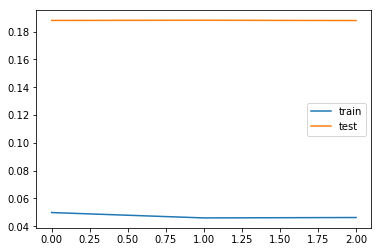

In [25]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [29]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [31]:
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))